# 4 Task A: Individual Neural Networks for Each Forecast Horizon

## 4.1 Data Preparation

In [71]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
import joblib
import random
import matplotlib.pyplot as plt
import torch.nn as nn
from scipy.stats import pearsonr
import math
from sklearn.metrics import mean_squared_error

### (a) Load the data from Nino3.4 data.csv

In [72]:
data = pd.read_csv("Nino3.4_data.csv")

### (b) Read test years from test years.csv. Extract all data rows from step (a) that match these test years to create your test set. This test data must remain untouched during training. You should use this test set to evaluate your model’s performance and report results

In [73]:
test_years = pd.read_csv("test_years.csv")["year"].tolist()

### (c) Subset your test data based on the test years, then randomly partition the remainingdataset into training and validation sets. Choose an appropriate split ratio that ensures sufficient data for both training and validation.

In [74]:
test_data = data[data["year"].isin(test_years)].reset_index(drop=True)
train_val_data = data[~data["year"].isin(test_years)].reset_index(drop=True)

# 在剩余数据中随机划分训练集与验证集
train_data, val_data = train_test_split(train_val_data, test_size=0.2, random_state=42, shuffle=True)

### (d) Pre-processing: Apply scaling transformations to the input features (nino tminus2, nino tminus1, nino t). Scaling the target variables (nino tplus1 through nino tplus6) is optional - if you choose to scale them, save the target scalers for inverse transformation during evaluation. Apply the same transformations to the validation set.

Optional: You might also consider creating additional features from the month column. For example, some students find it helpful to encode the cyclical nature of months using sine and cosine transformations: sin(2π × month/12) and cos(2π × month/12). This can help the model understand that December is adjacent to January.

Note: Save your scaler objects for later use (e.g., using pickle or joblib).

In [75]:
# 输入特征与目标列
input_features = ["nino_tminus2", "nino_tminus1", "nino_t"]
target_features = ["nino_tplus1", "nino_tplus2", "nino_tplus3", "nino_tplus4", "nino_tplus5", "nino_tplus6"]

# 可选：添加月份的正弦余弦特征
for df in [train_data, val_data, test_data]:
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

    # 将它们加入输入特征中
    df.reset_index(drop=True, inplace=True)

input_features_extended = input_features + ["month_sin", "month_cos"]

# 缩放输入特征
scaler_X = StandardScaler()
train_X_scaled = scaler_X.fit_transform(train_data[input_features_extended])
val_X_scaled = scaler_X.transform(val_data[input_features_extended])
test_X_scaled = scaler_X.transform(test_data[input_features_extended])

# 可选：缩放目标变量
scale_targets = True  # ← 如果不希望缩放，改成 False
if scale_targets:
    scaler_y = StandardScaler()
    train_y_scaled = scaler_y.fit_transform(train_data[target_features])
    val_y_scaled = scaler_y.transform(val_data[target_features])
    test_y_scaled = scaler_y.transform(test_data[target_features])

# 保存缩放器以供后续反缩放或预测使用
joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")

# ---------- 转换为 PyTorch 张量 ----------
train_X = torch.tensor(train_X_scaled, dtype=torch.float32)
val_X = torch.tensor(val_X_scaled, dtype=torch.float32)
test_X = torch.tensor(test_X_scaled, dtype=torch.float32)

train_y = torch.tensor(train_y_scaled, dtype=torch.float32)
val_y = torch.tensor(val_y_scaled, dtype=torch.float32)
test_y = torch.tensor(test_y_scaled, dtype=torch.float32)

# ---------- 创建 TensorDataset ----------
train_dataset = TensorDataset(train_X, train_y)
val_dataset = TensorDataset(val_X, val_y)
test_dataset = TensorDataset(test_X, test_y)

# 示例：构建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))
print("Test size:", len(test_dataset))

Train size: 584
Val size: 146
Test size: 72


### (e) Train a neural network that predicts the Ni˜no3.4 index of the next month, i.e.nino tplus1 using reasonable hyperparameters. Ensure reproducibility by setting a seed throughout your code. Plot the training and validation loss curves across epochs.
    Note: Save your trained models in a format appropriate for your chosen framework. Common formats include .keras, .h5, .pth, .pt, or .onnx. Ensure your models can be loaded during evaluation

In [76]:
# ---------- 设置随机种子以确保可复现性 ----------
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# 如果有GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- 定义神经网络 ----------
class NinoNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, dropout=0.1):
        super(NinoNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

input_dim = train_X.shape[1]
model = NinoNet(input_dim).to(device)


### (f) Repeat (e) for the subsequent months, i.e., nino_tplus2, nino_tplus3,.. nino_tplus6. Together with part (e), this will give you six trained networks and six plots for training and validation loss, shown in one Figure


===== Training Model for Horizon 1 Month =====
Epoch [5/1000] Train Loss: 0.6232, Val Loss: 0.5425
Epoch [10/1000] Train Loss: 0.3740, Val Loss: 0.3469
Epoch [15/1000] Train Loss: 0.2339, Val Loss: 0.2451
Epoch [20/1000] Train Loss: 0.1831, Val Loss: 0.2030
Epoch [25/1000] Train Loss: 0.1636, Val Loss: 0.1784
Epoch [30/1000] Train Loss: 0.1380, Val Loss: 0.1600
Epoch [35/1000] Train Loss: 0.1332, Val Loss: 0.1482
Epoch [40/1000] Train Loss: 0.1164, Val Loss: 0.1383
Epoch [45/1000] Train Loss: 0.1093, Val Loss: 0.1323
Epoch [50/1000] Train Loss: 0.1154, Val Loss: 0.1277
Epoch [55/1000] Train Loss: 0.1079, Val Loss: 0.1216
Epoch [60/1000] Train Loss: 0.0954, Val Loss: 0.1188
Epoch [65/1000] Train Loss: 0.0997, Val Loss: 0.1149
Epoch [70/1000] Train Loss: 0.0931, Val Loss: 0.1112
Epoch [75/1000] Train Loss: 0.0951, Val Loss: 0.1091
Epoch [80/1000] Train Loss: 0.0944, Val Loss: 0.1083
Epoch [85/1000] Train Loss: 0.0929, Val Loss: 0.1068
Epoch [90/1000] Train Loss: 0.0956, Val Loss: 0.1044

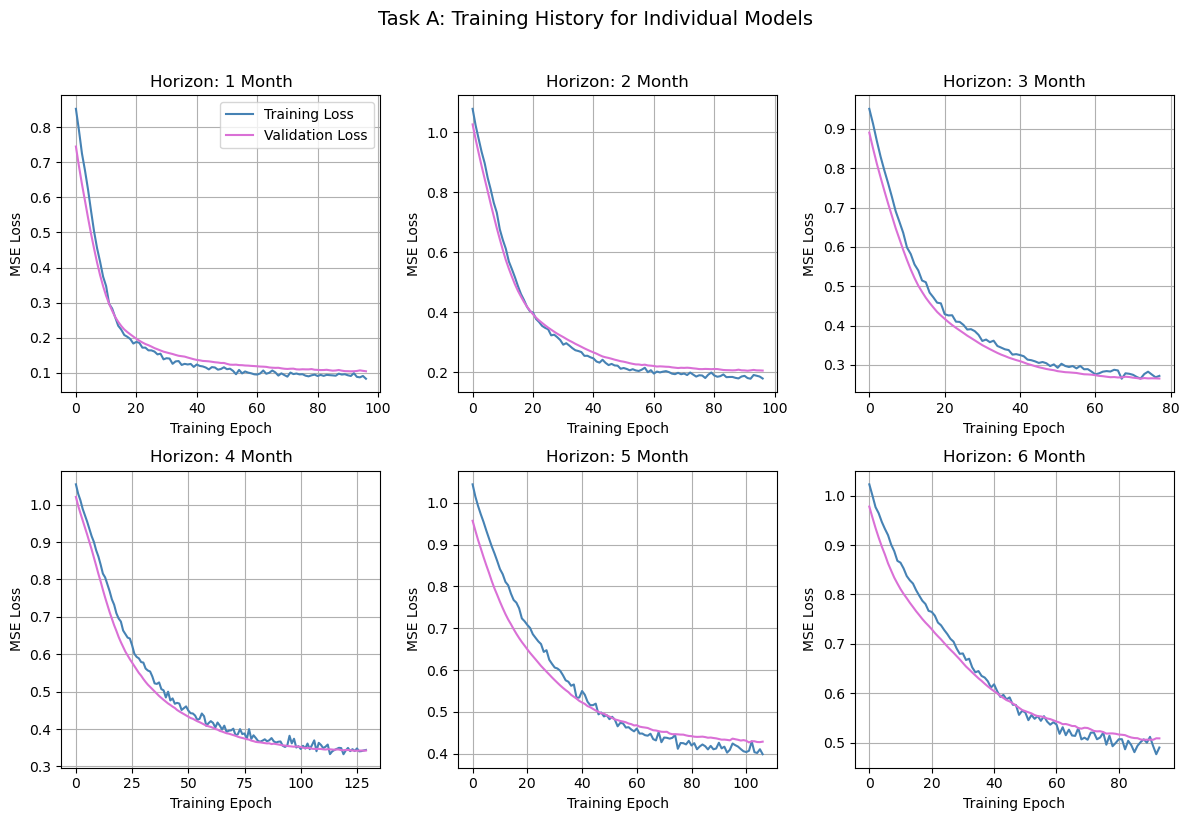

In [77]:
# ---------- 训练函数 ----------
def train_single_horizon(horizon_index, epochs=1000, lr=1e-4, batch_size=32, patience=5):
    # 目标列索引
    y_train_h = train_y[:, horizon_index].unsqueeze(1)
    y_val_h = val_y[:, horizon_index].unsqueeze(1)

    # 数据加载
    train_dataset = TensorDataset(train_X, y_train_h)
    val_dataset = TensorDataset(val_X, y_val_h)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # 模型定义
    model = NinoNet(train_X.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.MSELoss()

    # 记录损失
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0
    best_state = None

    for epoch in range(epochs):
        # --------- 训练 ---------
        model.train()
        total_train_loss = 0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * Xb.size(0)

        avg_train_loss = total_train_loss / len(train_loader.dataset)

        # --------- 验证 ---------
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                out = model(Xb)
                loss = criterion(out, yb)
                total_val_loss += loss.item() * Xb.size(0)
        avg_val_loss = total_val_loss / len(val_loader.dataset)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # --------- Early Stopping ---------
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}  # 保存最优权重
        else:
            patience_counter += 1

        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # 保存模型
    torch.save(model.state_dict(), f"nino_model_tplus{horizon_index+1}.pth")
    print(f" 模型 nino_model_tplus{horizon_index+1}.pth 已保存")
    
    # 载入最优权重
    model.load_state_dict(best_state)
    return model, train_losses, val_losses


# ---------- 主训练循环 ----------
all_train_losses, all_val_losses = [], []
num_models = 6
for i in range(num_models):
    print(f"\n===== Training Model for Horizon {i+1} Month =====")
    model, t_loss, v_loss = train_single_horizon(i)
    all_train_losses.append(t_loss)
    all_val_losses.append(v_loss)


# ---------- 绘制六张训练曲线 ----------
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i in range(num_models):
    ax = axes[i]
    ax.plot(all_train_losses[i], label="Training Loss", color="steelblue")
    ax.plot(all_val_losses[i], label="Validation Loss", color="orchid")
    ax.set_title(f"Horizon: {i+1} Month")
    ax.set_xlabel("Training Epoch")
    ax.set_ylabel("MSE Loss")
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.suptitle("Task A: Training History for Individual Models", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### (j) Apply the same transformations to the test set as you did to the training and validation sets

In [78]:
# 假设 scaler_X 是在 (d) 中已经 fit 过的输入特征缩放器
# 如果你也对目标缩放过（可选），那也有 scaler_y
# 加载保存好的 scaler
scaler_X = joblib.load('scaler_X.pkl')
scaler_y = joblib.load('scaler_y.pkl')

# ⚠️ 这里我们不重新fit，只transform
X_features = ['nino_tminus2', 'nino_tminus1', 'nino_t', 'month_sin', 'month_cos']
y_targets = ['nino_tplus1', 'nino_tplus2', 'nino_tplus3', 
             'nino_tplus4', 'nino_tplus5', 'nino_tplus6']

# 输入特征 transform（与训练集同一 scaler）
X_test_scaled = scaler_X.transform(test_data[X_features])
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)

# 为评估准备：不要对单列用 scaler_y.transform（会报错）
# 我们只保留原始真实值方便后面计算评估指标（以原始单位）
y_test_orig = test_data[y_targets].values  # shape (N,6)

print("测试集转换完成：")
print(f"X_test_tensor: {X_test_tensor.shape}, y_test_orig: {y_test_orig.shape}")

测试集转换完成：
X_test_tensor: torch.Size([72, 5]), y_test_orig: (72, 6)


### (k) Use your models to forecast the Ni˜no3.4 index on the test set for the months ahead they are designed for

In [79]:
# 假设模型结构一致
class NinoNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, dropout=0.1):
        super(NinoNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

# 载入模型并预测
horizons = [1, 2, 3, 4, 5, 6]
results = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# scaler_y.mean_ 和 scale_ 可用于单列反缩放
means = scaler_y.mean_        # 长度为6
scales = scaler_y.scale_      # 长度为6
# scaler_y.feature_names_in_ 也可用于确认列序


### (l) Evaluate each model by calculating the RMSE and Pearson Correlation Coefficient between the predicted and true values (as defined in Section 3.4).

In [80]:
for h in horizons:
    # 加载模型
    model = NinoNet(input_dim=X_test_tensor.shape[1]).to(device)
    model.load_state_dict(torch.load(f"nino_model_tplus{h}.pth", map_location=device))
    model.eval()  # 重要：关闭 Dropout

    # 预测
    with torch.no_grad():
        preds_scaled = model(X_test_tensor).cpu().numpy().reshape(-1,1)  # (N,1)

    # 反缩放 - 使用 scaler_y 对应列的 mean/scale（手动反缩放，避免 sklearn 的列名校验）
    col_idx = h - 1  # tplus1 -> idx0, tplus6 -> idx5
    preds_orig = preds_scaled * scales[col_idx] + means[col_idx]  # (N,1)
    true_orig = y_test_orig[:, col_idx].reshape(-1,1)            # (N,1)

    # 评估在原尺度
    rmse = math.sqrt(mean_squared_error(true_orig, preds_orig))
    corr, _ = pearsonr(true_orig.flatten(), preds_orig.flatten())

    results.append({"Horizon (month ahead)": h, "RMSE": rmse, "Pearson r": corr})

### (m) Display results in a table showing RMSE and correlation coefficients for each forecast horizon (1-6 months ahead

In [81]:
# 汇总结果表
results_df_A = pd.DataFrame(results)
print("📊 预测评估结果：")
print(results_df_A.to_string(index=False))

📊 预测评估结果：
 Horizon (month ahead)     RMSE  Pearson r
                     1 0.222679   0.973228
                     2 0.356924   0.927746
                     3 0.464249   0.871606
                     4 0.588196   0.786149
                     5 0.652518   0.731693
                     6 0.727940   0.651093


## 4.4 Model Improvements
### (n) Apply a strategy that involves transfer learning to the model that predicts nino tplus6 and calculate the RMSE and correlation coefficient on the testing data.
    Hint: First train a model on an easier task such as nino tplus1, then continue training the same model to predict nino tplus6

In [82]:
# ---------- (n) Transfer Learning for Nino_tplus6 (修正后) ----------
# 使用之前的 train_X_scaled, test_X_scaled，和 scaler_y 的 mean/scale 做单列缩放

# 准备 tensors
X_train_tensor = torch.tensor(train_X_scaled, dtype=torch.float32).to(device)
X_test_tensor  = torch.tensor(test_X_scaled, dtype=torch.float32).to(device)

# 手动缩放单列 target（使用 scaler_y.mean_ / scale_）
col_idx = list(scaler_y.feature_names_in_).index('nino_tplus6')  # 确认索引
y_train_tplus6 = train_data[['nino_tplus6']].values.astype(float).reshape(-1,1)
y_test_tplus6  = test_data[['nino_tplus6']].values.astype(float).reshape(-1,1)

y_train_tplus6_scaled = (y_train_tplus6 - scaler_y.mean_[col_idx]) / scaler_y.scale_[col_idx]
y_test_tplus6_scaled  = (y_test_tplus6  - scaler_y.mean_[col_idx]) / scaler_y.scale_[col_idx]

y_train_tplus6_tensor = torch.tensor(y_train_tplus6_scaled, dtype=torch.float32).to(device)
y_test_tplus6_tensor  = torch.tensor(y_test_tplus6_scaled, dtype=torch.float32).to(device)

# 加载模型并替换最后层
source_model_path = "nino_model_tplus1.pth"
target_model_path = "nino_model_transfer_tplus6.pth"

input_dim = X_train_tensor.shape[1]
model = NinoNet(input_dim).to(device)
model.load_state_dict(torch.load(source_model_path, map_location=device))

# 替换输出层（确保输出是单一回归）
model.model[-1] = nn.Linear(32, 1).to(device)

# 冻结底层 1~2 层，微调中间层 + 输出层，让模型有能力适应 tplus6
for p in model.model[:2].parameters():  # 冻结前两层
    p.requires_grad = False
for p in model.model[2:].parameters():  # 微调后两层
    p.requires_grad = True

# 重新定义优化器（只包含可训练参数）
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                       lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()

# 划分验证子集以基于 val_loss 做 early stopping
from sklearn.model_selection import train_test_split
X_tr_sub, X_val_sub, y_tr_sub, y_val_sub = train_test_split(
    X_train_tensor.cpu(), y_train_tplus6_tensor.cpu(), test_size=0.2, random_state=42
)
X_tr_sub, X_val_sub = X_tr_sub.to(device), X_val_sub.to(device)
y_tr_sub, y_val_sub = y_tr_sub.to(device), y_val_sub.to(device)

best_val_loss = float('inf')
patience = 5   # 允许连续多少个 epoch val_loss 不降
patience_counter = 0
epochs = 3000

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(X_tr_sub)
    loss = criterion(out, y_tr_sub)
    loss.backward()
    optimizer.step()
    
    # 验证集评估
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_sub)
        val_loss = criterion(val_pred, y_val_sub)

    
    # Early stopping 检查
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        patience_counter = 0
        # 保存当前最优权重（可选）
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
    else:
        patience_counter += 1

    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# 保存最优权重（若有 best_state 用 best_state）
if 'best_state' in locals():
    torch.save(best_state, target_model_path)
else:
    torch.save(model.state_dict(), target_model_path)
print("迁移模型已保存：", target_model_path)

# 在测试集上评估（反缩放）
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_tensor).cpu().numpy()  # (N,1)

# 反缩放
y_pred_orig = y_pred_scaled * scaler_y.scale_[col_idx] + scaler_y.mean_[col_idx]
y_true_orig = y_test_tplus6  # 已在前面定义为原始真实值

rmse_transfer = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
corr_transfer, _ = pearsonr(y_true_orig.flatten(), y_pred_orig.flatten())

print("\n📈 Transfer Learning Results for Nino_tplus6:")
print(f"RMSE: {rmse_transfer:.4f}")
print(f"Pearson r: {corr_transfer:.4f}")

Epoch [5/3000] Train Loss: 1.0840, Val Loss: 1.1724
Epoch [10/3000] Train Loss: 0.9404, Val Loss: 1.0767
Epoch [15/3000] Train Loss: 0.8588, Val Loss: 1.0141
Epoch [20/3000] Train Loss: 0.8065, Val Loss: 0.9639
Epoch [25/3000] Train Loss: 0.7469, Val Loss: 0.9214
Epoch [30/3000] Train Loss: 0.7189, Val Loss: 0.8850
Epoch [35/3000] Train Loss: 0.6740, Val Loss: 0.8525
Epoch [40/3000] Train Loss: 0.6578, Val Loss: 0.8236
Epoch [45/3000] Train Loss: 0.6195, Val Loss: 0.7991
Epoch [50/3000] Train Loss: 0.5987, Val Loss: 0.7781
Epoch [55/3000] Train Loss: 0.5776, Val Loss: 0.7595
Epoch [60/3000] Train Loss: 0.5695, Val Loss: 0.7418
Epoch [65/3000] Train Loss: 0.5380, Val Loss: 0.7269
Epoch [70/3000] Train Loss: 0.5280, Val Loss: 0.7137
Epoch [75/3000] Train Loss: 0.5127, Val Loss: 0.7023
Epoch [80/3000] Train Loss: 0.5111, Val Loss: 0.6933
Epoch [85/3000] Train Loss: 0.5000, Val Loss: 0.6860
Epoch [90/3000] Train Loss: 0.5051, Val Loss: 0.6787
Epoch [95/3000] Train Loss: 0.4887, Val Loss: 0

# Task B: Multi-Output Neural Network

## 5.1 Neural Network Development

### (o) Subset your test data based on the test years, then randomly partition the remaining dataset into training and validation sets. Choose an appropriate split ratio that ensures sufficient data for both training and validation

### (p) Pre-processing: Apply scaling transformations to the input features (nino tminus2, nino tminus1, nino t). Scaling the target variables (nino tplus1 through nino tplus6) is optional - if you choose to scale them, save the target scalers for inverse trans- formation during evaluation. Apply the same transformations to the validation set.
    Note: Save your scaler objects for later use (e.g., using pickle or joblib).

### (q) Hyperparameter Tuning: Build and optimise a multi-output neural network that simultaneously predicts all six future months (nino tplus1 through nino tplus6) in a single forward pass. Note that your output layer must have 6 neurons corresponding to these six predictions. 
    Start with a reasonable baseline architecture and systematically explore how changes in network depth, width, and learning rate affect performance to prevent overfitting.

In [83]:
# task b-standard multi-output model
# ---------- 设置随机种子以确保可复现性 ----------
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ---------- 定义多输出神经网络 ----------
class MultiOutputNinoNet(nn.Module):
    def __init__(self, input_dim, output_dim=6):
        super(MultiOutputNinoNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.model(x)


# ---------- 训练函数 ----------
def train_multi_output(epochs=1000, lr=1e-4, batch_size=32, patience=5):
    # 数据加载
    train_dataset = TensorDataset(train_X, train_y)
    val_dataset = TensorDataset(val_X, val_y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # 模型定义（保持与e完全一致）
    model = MultiOutputNinoNet(train_X.shape[1], output_dim=train_y.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.MSELoss()

    # 记录损失
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0
    best_state = None

    for epoch in range(epochs):
        # --------- 训练 ---------
        model.train()
        total_train_loss = 0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * Xb.size(0)

        avg_train_loss = total_train_loss / len(train_loader.dataset)

        # --------- 验证 ---------
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                out = model(Xb)
                loss = criterion(out, yb)
                total_val_loss += loss.item() * Xb.size(0)
        avg_val_loss = total_val_loss / len(val_loader.dataset)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # --------- Early Stopping ---------
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1

        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # 保存最优模型
    torch.save(model.state_dict(), "nino_model_multi_output.pth")
    print("🌊 多输出模型已保存：nino_model_multi_output.pth")

    # 载入最优权重
    model.load_state_dict(best_state)
    return model, train_losses, val_losses

# ---------- 主训练循环 ----------
print("\n===== Training Multi-Output Model =====")
model_multi, train_losses, val_losses = train_multi_output(
    epochs=1000, lr=1e-4, batch_size=32, patience=5
)


===== Training Multi-Output Model =====
Epoch [5/1000] Train Loss: 0.9520, Val Loss: 0.8871
Epoch [10/1000] Train Loss: 0.8473, Val Loss: 0.7814
Epoch [15/1000] Train Loss: 0.7152, Val Loss: 0.6647
Epoch [20/1000] Train Loss: 0.6057, Val Loss: 0.5701
Epoch [25/1000] Train Loss: 0.5350, Val Loss: 0.5131
Epoch [30/1000] Train Loss: 0.4937, Val Loss: 0.4768
Epoch [35/1000] Train Loss: 0.4566, Val Loss: 0.4497
Epoch [40/1000] Train Loss: 0.4360, Val Loss: 0.4260
Epoch [45/1000] Train Loss: 0.4047, Val Loss: 0.4048
Epoch [50/1000] Train Loss: 0.3869, Val Loss: 0.3874
Epoch [55/1000] Train Loss: 0.3687, Val Loss: 0.3727
Epoch [60/1000] Train Loss: 0.3609, Val Loss: 0.3566
Epoch [65/1000] Train Loss: 0.3521, Val Loss: 0.3469
Epoch [70/1000] Train Loss: 0.3294, Val Loss: 0.3372
Epoch [75/1000] Train Loss: 0.3318, Val Loss: 0.3293
Epoch [80/1000] Train Loss: 0.3243, Val Loss: 0.3255
Epoch [85/1000] Train Loss: 0.3167, Val Loss: 0.3206
Epoch [90/1000] Train Loss: 0.3102, Val Loss: 0.3189
Epoch 

### (r) Training Visualisation: Create a plot showing the training and validation loss curves for your best model.
    Note: Save your trained model in a format appropriate for your chosen fram

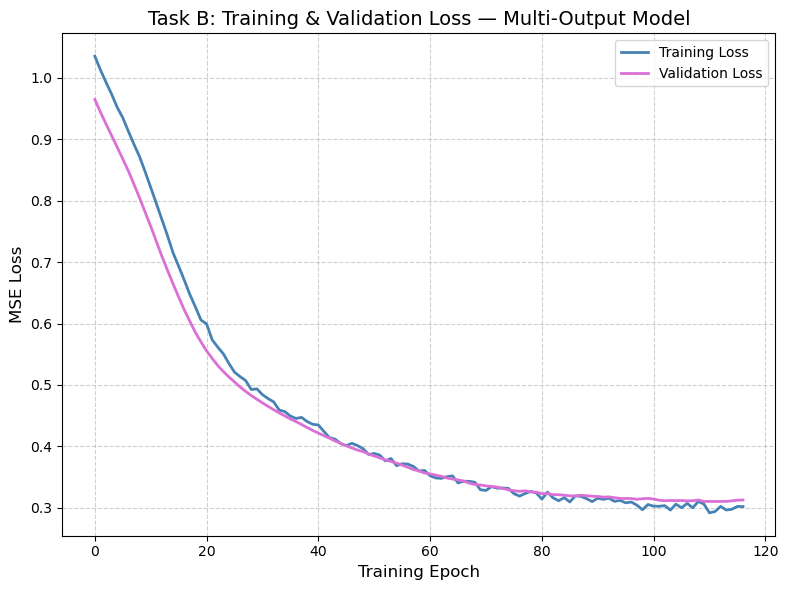

In [84]:
# ---------- 绘制训练与验证曲线 ----------
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss", color="steelblue", linewidth=2)
plt.plot(val_losses, label="Validation Loss", color="orchid", linewidth=2)

plt.title("Task B: Training & Validation Loss — Multi-Output Model", fontsize=14)
plt.xlabel("Training Epoch", fontsize=12)
plt.ylabel("MSE Loss", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

## 5.2  Model Evaluation
### (s) Calculate performance metrics on the testing data for each output (all 6 forecast horizons) using the metrics defined in Section 3.4

In [85]:
# 转为 CPU numpy 格式
X_test_np = X_test_tensor.cpu().numpy()
y_test_np = y_test_orig  # (N, 6)

# ---------- 载入模型并预测 ----------
model = MultiOutputNinoNet(input_dim=X_test_tensor.shape[1])
model.load_state_dict(torch.load("nino_model_multi_output.pth", map_location="cpu"))
model.eval()

with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()  # shape (N, 6)

# ---------- 反缩放预测值与真实值 ----------
if 'scaler_y' in globals() and scale_targets:
    # 注意：scaler_y 是 fit 在训练集 target_features 上的
    y_pred = scaler_y.inverse_transform(y_pred)
    y_true = scaler_y.inverse_transform(test_y_scaled)  # ← 确保这是 test_y_scaled
else:
    y_pred = y_pred_scaled
    y_true = y_test_orig  # 如果没缩放，直接用原值

# ---------- 计算每个预测步的 RMSE 和 Pearson r ----------

rmse_list_B, r_list_B = [], []
for i in range(6):
    rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
    r, _ = pearsonr(y_true[:, i], y_pred[:, i])
    rmse_list_B.append(rmse)
    r_list_B.append(r)
    print(f"Horizon {i+1}: RMSE = {rmse:.4f}, Pearson r = {r:.4f}")

results_df_B = pd.DataFrame({
    "Horizon (month ahead)": np.arange(1, 7),
    "RMSE": rmse_list_B,
    "Pearson r": r_list_B
})

print("\n📈 Multi-Output Model Test Performance:")
print(results_df_B.to_string(index=False))

Horizon 1: RMSE = 0.1954, Pearson r = 0.9787
Horizon 2: RMSE = 0.3387, Pearson r = 0.9330
Horizon 3: RMSE = 0.4626, Pearson r = 0.8716
Horizon 4: RMSE = 0.5740, Pearson r = 0.7941
Horizon 5: RMSE = 0.6549, Pearson r = 0.7203
Horizon 6: RMSE = 0.7268, Pearson r = 0.6480

📈 Multi-Output Model Test Performance:
 Horizon (month ahead)     RMSE  Pearson r
                     1 0.195390   0.978731
                     2 0.338664   0.933041
                     3 0.462599   0.871603
                     4 0.573999   0.794111
                     5 0.654880   0.720330
                     6 0.726799   0.648011


### (t) Create scatter plots of predicted vs observed values with RMSE and correlation metrics for each forecast horizon, as shown in Figure 3

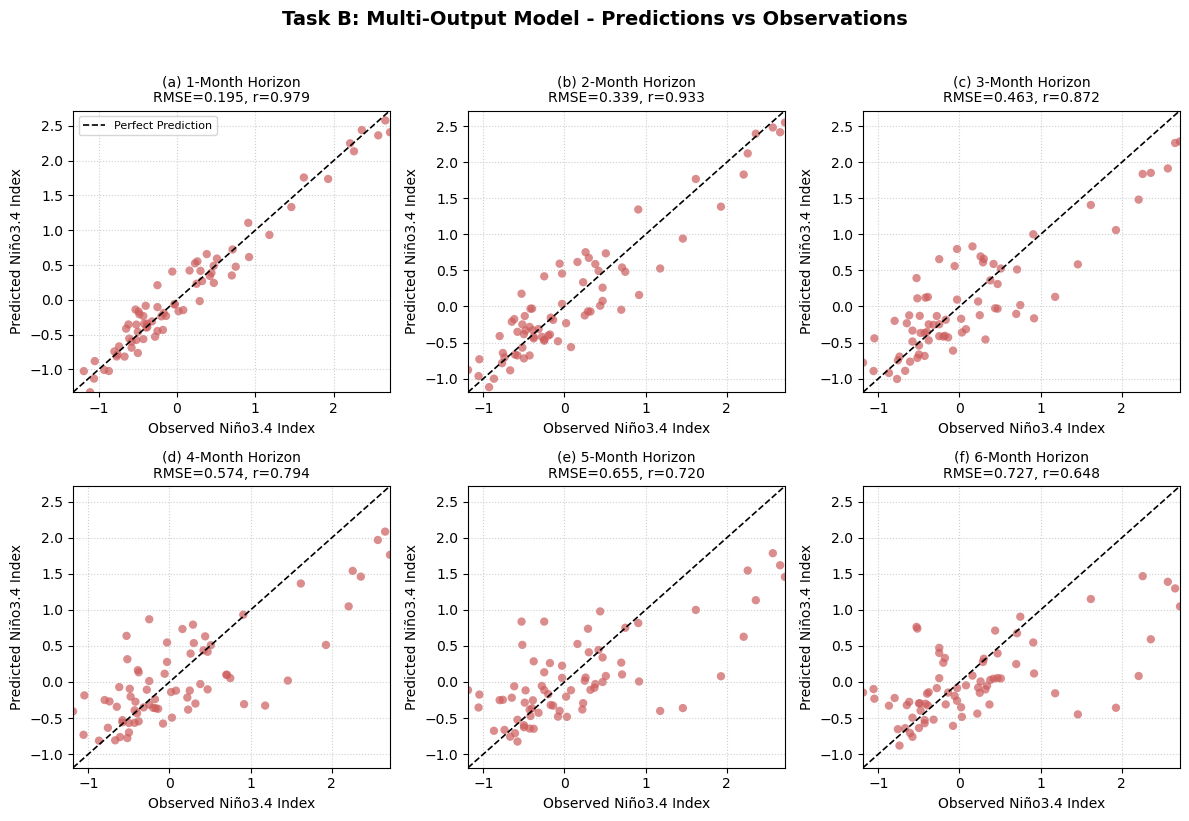

In [86]:
# ---------- (t) Scatter Plots: Predicted vs Observed ----------

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

titles = [
    "(a) 1-Month Horizon",
    "(b) 2-Month Horizon",
    "(c) 3-Month Horizon",
    "(d) 4-Month Horizon",
    "(e) 5-Month Horizon",
    "(f) 6-Month Horizon"
]

for i, ax in enumerate(axes):
    # 散点
    ax.scatter(
        y_true[:, i], y_pred[:, i],
        color="indianred", alpha=0.7, edgecolor="none"
    )

    # 完美预测线
    min_val = min(y_true[:, i].min(), y_pred[:, i].min())
    max_val = max(y_true[:, i].max(), y_pred[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1.2, label="Perfect Prediction")

    # 坐标与标签
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.set_title(f"{titles[i]}\nRMSE={rmse_list_B[i]:.3f}, r={r_list_B[i]:.3f}", fontsize=10)
    ax.set_xlabel("Observed Niño3.4 Index")
    ax.set_ylabel("Predicted Niño3.4 Index")
    ax.grid(True, linestyle=":", alpha=0.6)

    if i == 0:
        ax.legend(loc="upper left", fontsize=8)

plt.suptitle("Task B: Multi-Output Model - Predictions vs Observations", fontsize=14, weight="bold", y=1.02)
plt.tight_layout()
plt.show()

## 5.3 Model Improvements
### (u) Propose and implement a strategy that could improve the performance of such a multi-output model.
    Hint: think about modifying the loss function so that it gives different weights to different outputs, or combining errors in a customised way instead of using the default mean squared error.
    Note: Save this improved model separately from your standard Task B model.

In [91]:
# ---------- 改进后的自适应加权训练函数 ----------
def train_multi_output_weighted(epochs=1000, lr=1e-4, batch_size=32, patience=5):
    # 数据加载
    train_dataset = TensorDataset(train_X, train_y)
    val_dataset = TensorDataset(val_X, val_y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # 模型与优化器
    model = MultiOutputNinoNet(train_X.shape[1], output_dim=train_y.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    # 初始均匀权重（动态更新）
    weights = torch.ones(train_y.shape[1], dtype=torch.float32).to(device)

    # 加权 MSE Loss
    def weighted_mse_loss(pred, target, weights):
        mse = (pred - target) ** 2
        return torch.mean(mse * weights)  # 广播乘法自动对齐维度

    # Early stopping 初始化
    train_losses, val_losses = [], []
    best_val_loss = float("inf")
    patience_counter = 0
    best_state = None

    # ---------- 主训练循环 ----------
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(Xb)
            loss = weighted_mse_loss(out, yb, weights)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * Xb.size(0)

        avg_train_loss = total_train_loss / len(train_loader.dataset)

        # ---------- 验证阶段 ----------
        model.eval()
        total_val_loss = 0
        all_pred, all_true = [], []
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                out = model(Xb)
                all_pred.append(out.cpu())
                all_true.append(yb.cpu())
                loss = weighted_mse_loss(out, yb, weights)
                total_val_loss += loss.item() * Xb.size(0)
        avg_val_loss = total_val_loss / len(val_loader.dataset)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # ---------- 动态调整权重 ----------
        y_pred = torch.cat(all_pred, dim=0).numpy()
        y_true = torch.cat(all_true, dim=0).numpy()

        rmse_list = np.sqrt(np.mean((y_pred - y_true) ** 2, axis=0))
        weights_np = 1 / (rmse_list + 1e-6)
        weights_np = weights_np / weights_np.mean()
        weights = torch.tensor(weights_np, dtype=torch.float32).to(device)

        # ---------- Early Stopping ----------
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1

        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] "
                  f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
            print(f"    Dynamic weights: {weights_np.round(3)}")

        if patience_counter >= patience:
            print(f"🌙 Early stopping at epoch {epoch+1}")
            break

    # ---------- 保存模型 ----------
    model.load_state_dict(best_state)
    torch.save(model.state_dict(), "nino_model_multi_output_weighted.pth")
    print("🌊 自适应加权多输出模型已保存：nino_model_multi_output_weighted.pth")

    return model, train_losses, val_losses


# ---------- 训练主循环 ----------
print("\n===== Training Adaptive Weighted Multi-Output Model =====")
model_weighted, _, _ = train_multi_output_weighted(
    epochs=1000, lr=1e-4, batch_size=32, patience=5
)


===== Training Adaptive Weighted Multi-Output Model =====
Epoch [5/1000] Train Loss: 0.9455, Val Loss: 0.8794
    Dynamic weights: [1.041 1.072 0.912 0.965 1.02  0.989]
Epoch [10/1000] Train Loss: 0.8401, Val Loss: 0.7728
    Dynamic weights: [1.118 1.103 0.894 0.946 0.985 0.955]
Epoch [15/1000] Train Loss: 0.7071, Val Loss: 0.6442
    Dynamic weights: [1.25  1.142 0.882 0.918 0.919 0.889]
Epoch [20/1000] Train Loss: 0.5790, Val Loss: 0.5383
    Dynamic weights: [1.377 1.176 0.883 0.888 0.859 0.817]
Epoch [25/1000] Train Loss: 0.4983, Val Loss: 0.4691
    Dynamic weights: [1.45  1.193 0.898 0.87  0.82  0.77 ]
Epoch [30/1000] Train Loss: 0.4349, Val Loss: 0.4240
    Dynamic weights: [1.482 1.203 0.914 0.86  0.8   0.741]
Epoch [35/1000] Train Loss: 0.3995, Val Loss: 0.3897
    Dynamic weights: [1.519 1.207 0.921 0.851 0.784 0.719]
Epoch [40/1000] Train Loss: 0.3610, Val Loss: 0.3604
    Dynamic weights: [1.552 1.206 0.925 0.844 0.771 0.702]
Epoch [45/1000] Train Loss: 0.3441, Val Loss: 

Horizon 1: RMSE = 0.1943, Pearson r = 0.9795
Horizon 2: RMSE = 0.3328, Pearson r = 0.9368
Horizon 3: RMSE = 0.4733, Pearson r = 0.8690
Horizon 4: RMSE = 0.5781, Pearson r = 0.7912
Horizon 5: RMSE = 0.6614, Pearson r = 0.7173
Horizon 6: RMSE = 0.7386, Pearson r = 0.6369


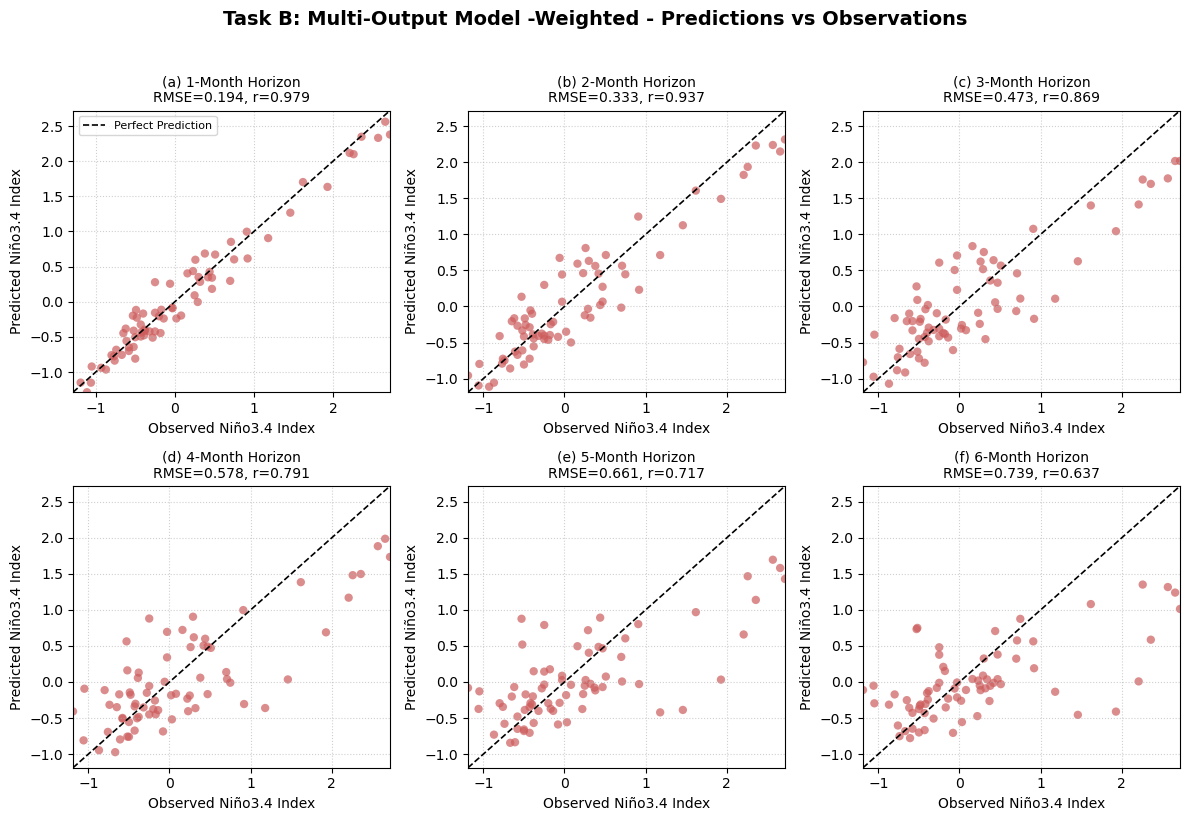

In [92]:
# ---------- 载入模型并预测 ----------
model = MultiOutputNinoNet(input_dim=X_test_tensor.shape[1])
model.load_state_dict(torch.load("nino_model_multi_output_weighted.pth", map_location="cpu"))
model.eval()

with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()  # shape (N, 6)

# ---------- 反缩放预测值与真实值 ----------
if 'scaler_y' in globals() and scale_targets:
    # 注意：scaler_y 是 fit 在训练集 target_features 上的
    y_pred = scaler_y.inverse_transform(y_pred)
    y_true = scaler_y.inverse_transform(test_y_scaled)  # ← 确保这是 test_y_scaled

# ---------- 计算每个预测步的 RMSE 和 Pearson r ----------

rmse_weighted, r_weighted = [], []
for i in range(6):
    rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
    r, _ = pearsonr(y_true[:, i], y_pred[:, i])
    rmse_weighted.append(rmse)
    r_weighted.append(r)
    print(f"Horizon {i+1}: RMSE = {rmse:.4f}, Pearson r = {r:.4f}")

# ---------- Scatter Plots: Predicted vs Observed ----------

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

titles = [
    "(a) 1-Month Horizon",
    "(b) 2-Month Horizon",
    "(c) 3-Month Horizon",
    "(d) 4-Month Horizon",
    "(e) 5-Month Horizon",
    "(f) 6-Month Horizon"
]

for i, ax in enumerate(axes):
    # 散点
    ax.scatter(
        y_true[:, i], y_pred[:, i],
        color="indianred", alpha=0.7, edgecolor="none"
    )

    # 完美预测线
    min_val = min(y_true[:, i].min(), y_pred[:, i].min())
    max_val = max(y_true[:, i].max(), y_pred[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1.2, label="Perfect Prediction")

    # 坐标与标签
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.set_title(f"{titles[i]}\nRMSE={rmse_weighted[i]:.3f}, r={r_weighted[i]:.3f}", fontsize=10)
    ax.set_xlabel("Observed Niño3.4 Index")
    ax.set_ylabel("Predicted Niño3.4 Index")
    ax.grid(True, linestyle=":", alpha=0.6)

    if i == 0:
        ax.legend(loc="upper left", fontsize=8)

plt.suptitle("Task B: Multi-Output Model -Weighted - Predictions vs Observations", fontsize=14, weight="bold", y=1.02)
plt.tight_layout()
plt.show()

# 6 Comparison and Analysis

## 6.1 Comparison Requirements
### (w) Create a comparison table showing RMSE and correlation coefficients for all 6 forecast horizons, comparing: (1) Task A individual models, (2) Task B standard model(baseline), and (3) Task B improved model with weighted loss. Include average performance and calculate relative improvement percentages using Task B standard model as the baseline reference

In [93]:
# ---------- (w) Model Comparison Table ----------
# 假设你已经有三个模型在测试集上的指标：
# Task A 单目标模型 (list of dicts)
taskA_results = results_df_A.copy()  # 来自你单目标模型循环预测

# Task A 迁移学习模型 (t+6)
taskA_transfer_rmse = [np.nan]*5 + [rmse_transfer]
taskA_transfer_r = [np.nan]*5 + [corr_transfer]

# Task B standard 多输出模型
taskB_standard_rmse = rmse_list_B.copy()   # 多输出模型预测 RMSE
taskB_standard_r = r_list_B.copy()         # 多输出模型 Pearson r

# Task B weighted 多输出模型
taskB_weighted_rmse = rmse_weighted.copy()   # 自适应加权模型预测 RMSE
taskB_weighted_r = r_weighted.copy()         # Pearson r

# 如果你在前面运行了多输出加权模型预测，确保用不同变量存储
# 比如 weighted_rmse_list, weighted_r_list
# 我这里假设已经存储在 taskB_weighted_rmse, taskB_weighted_r

horizons = np.arange(1, 7)
comparison_df = pd.DataFrame({
    "Horizon": horizons,
    "Task A RMSE": taskA_results["RMSE"].tolist(),
    "Task A r": taskA_results["Pearson r"].tolist(),
    "Task A Transfer RMSE": taskA_transfer_rmse,
    "Task A Transfer r": taskA_transfer_r,
    "Task B Standard RMSE": taskB_standard_rmse,
    "Task B Standard r": taskB_standard_r,
    "Task B Weighted RMSE": taskB_weighted_rmse,
    "Task B Weighted r": taskB_weighted_r
})

# 平均值
avg_row = pd.DataFrame({
    "Horizon": ["Average"],
    "Task A RMSE": [np.nanmean(comparison_df["Task A RMSE"])],
    "Task A r": [np.nanmean(comparison_df["Task A r"])],
    "Task A Transfer RMSE": [np.nanmean([x for x in taskA_transfer_rmse if not np.isnan(x)])],
    "Task A Transfer r": [np.nanmean([x for x in taskA_transfer_r if not np.isnan(x)])],
    "Task B Standard RMSE": [np.mean(taskB_standard_rmse)],
    "Task B Standard r": [np.mean(taskB_standard_r)],
    "Task B Weighted RMSE": [np.mean(taskB_weighted_rmse)],
    "Task B Weighted r": [np.mean(taskB_weighted_r)]
})
comparison_df = pd.concat([comparison_df, avg_row], ignore_index=True)

# 相对改进百分比 (以 Task B Standard 为基准)
comparison_df["Weighted RMSE Improvement (%)"] = 100 * (
    (comparison_df["Task B Standard RMSE"] - comparison_df["Task B Weighted RMSE"])
    / comparison_df["Task B Standard RMSE"]
)
comparison_df["Weighted r Improvement (%)"] = 100 * (
    (comparison_df["Task B Weighted r"] - comparison_df["Task B Standard r"])
    / comparison_df["Task B Standard r"]
)

# 显示结果
pd.set_option("display.float_format", "{:.4f}".format)
print("📊 Model Comparison Table (4 Models, including Task A Transfer Learning for t+6):")
print(comparison_df.to_string(index=False))

📊 Model Comparison Table (4 Models, including Task A Transfer Learning for t+6):
Horizon  Task A RMSE  Task A r  Task A Transfer RMSE  Task A Transfer r  Task B Standard RMSE  Task B Standard r  Task B Weighted RMSE  Task B Weighted r  Weighted RMSE Improvement (%)  Weighted r Improvement (%)
      1       0.2227    0.9732                   NaN                NaN                0.1954             0.9787                0.1943             0.9795                         0.5655                      0.0757
      2       0.3569    0.9277                   NaN                NaN                0.3387             0.9330                0.3328             0.9368                         1.7205                      0.4078
      3       0.4642    0.8716                   NaN                NaN                0.4626             0.8716                0.4733             0.8690                        -2.3115                     -0.2948
      4       0.5882    0.7861                   NaN               

### (x) Generate comparison visualisations showing RMSE and correlation trends across forecast horizons for both approaches, as shown in Figu